<a href="https://colab.research.google.com/github/arijitar/Diabetic-Retinopathy-detection/blob/main/Resnet152.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import modules

In [ ]:
# Loading all the neccessary libraries as per the requirement i.e.
# 1. Reading the files = os
# 2. Image Processing  = cv2
# 3. Deep Learning  = tensorflow
# 4. Splitting the data & Endcoding the Labels = sklearn
# 5. For cleaning memory = gc
!pip install tensorflow
!pip install opencv-python
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv2DTranspose, Conv2D, LeakyReLU, MaxPooling2D, Dropout, concatenate, GlobalAveragePooling2D, Cropping2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import gc
from tensorflow.keras.models import load_model


# Mount the Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load the Preprosessed Image List and Label List or Processing images from scratch...



In [ ]:
if os.path.exists('/content/drive/MyDrive/preprocessed_images.npy') and os.path.exists('/content/drive/MyDrive/preprocessed_labels.npy'):
    print("Loading preprocessed data from disk...")
    images = np.load('/content/drive/MyDrive/preprocessed_images.npy')
    labels = np.load('/content/drive/MyDrive/preprocessed_labels.npy')
else:
    print("Processing images from scratch...")
    path = '/content/drive/MyDrive/Aug_DataSet1'
    image_type_folders = os.listdir(path)
    image_size = 299
    images = []
    labels = []
    for folder in image_type_folders:
        folder_path = os.path.join(path, folder)
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (image_size, image_size))
            images.append(img)
            labels.append(folder.strip().lower())
    images = np.array(images).astype('float32') / 255.0
    labels = np.array(labels)
    np.save('/content/drive/MyDrive/preprocessed_images.npy', images)
    np.save('/content/drive/MyDrive/preprocessed_labels.npy', labels)

Loading preprocessed data from disk...


# One Hot Encoding

In [ ]:
# Encode labels
le = LabelEncoder()
labels = le.fit_transform(labels)
Y = to_categorical(labels)
# Y = np.array(labels).reshape(-1, 1)  # shape = (num_samples, 1)

# Split the dataset into training and testing set

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(images, Y, test_size=0.1, random_state=42)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(10390, 299, 299, 3)
(1155, 299, 299, 3)
(10390, 2)
(1155, 2)


# Split into validation set

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Resize image array according to model input

In [ ]:
# Function to resize images
def resize_images_array(images_array, target_size):
    resized_images = []
    for img in images_array:
        resized_img = cv2.resize(img, target_size)
        resized_images.append(resized_img)
    return np.array(resized_images)

target_size = (224, 224)
x_train = resize_images_array(x_train, target_size)
x_val = resize_images_array(x_val, target_size)
x_test = resize_images_array(x_test, target_size)

In [ ]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(8312, 224, 224, 3)
(2078, 224, 224, 3)
(1155, 224, 224, 3)


# Create generators (Here it is optional)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1.0)

train_generator = datagen.flow(x_train, y_train, batch_size=64, shuffle=True)
val_generator = datagen.flow(x_val, y_val, batch_size=64, shuffle=False)
test_generator = datagen.flow(x_test, y_test, batch_size=64, shuffle=False)

num_classes = 2

# Base ResNet152 Model and compile

#  unfreeze 40 layers

In [ ]:
from tensorflow.keras.applications import ResNet152

input_shape = (224,224,3)
base_model = ResNet152(include_top=False, weights='imagenet', input_shape=input_shape)

for layer in base_model.layers[-40:]:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)  # Add extra layer
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 58,896,002 (224.67 MB)

 Trainable params: 58,744,578 (224.09 MB)

 Non-trainable params: 151,424 (591.50 KB)

# Callbacks: Early Stopping

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

earlystop_cb = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True
)


reduce_lr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=10,
    min_lr=1e-6,
    verbose=1
)

callabacks = [earlystop_cb, reduce_lr_cb]

In [ ]:
from tensorflow.keras import backend as K
K.clear_session()

# Train the Model

In [ ]:
history = model.fit(train_generator, validation_data=val_generator, epochs=100, callbacks=callabacks)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


130/130 ━━━━━━━━━━━━━━━━━━━━ 251s 755ms/step - accuracy: 0.8665 - loss: 0.3953 - val_accuracy: 0.5144 - val_loss: 0.6943 - learning_rate: 0.0010
Epoch 2/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 26s 203ms/step - accuracy: 0.9416 - loss: 0.1488 - val_accuracy: 0.5144 - val_loss: 0.6987 - learning_rate: 0.0010
Epoch 3/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 26s 201ms/step - accuracy: 0.9527 - loss: 0.1268 - val_accuracy: 0.5144 - val_loss: 0.7008 - learning_rate: 0.0010
Epoch 4/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 27s 205ms/step - accuracy: 0.9663 - loss: 0.0919 - val_accuracy: 0.5366 - val_loss: 0.6936 - learning_rate: 0.0010
Epoch 5/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 27s 204ms/step - accuracy: 0.9726 - loss: 0.0686 - val_accuracy: 0.5953 - val_loss: 0.6358 - learning_rate: 0.0010
Epoch 6/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 27s 204ms/step - accuracy: 0.9739 - loss: 0.0729 - val_accuracy: 0.7512 - val_loss: 0.4969 - learning_rate: 0.0010
Epoch 7/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 27s 205ms/step - accuracy: 0.9760 

#  unfreeze 15 layers

In [ ]:
from tensorflow.keras.applications import ResNet152

input_shape = (224,224,3)
base_model = ResNet152(include_top=False, weights='imagenet', input_shape=input_shape)

for layer in base_model.layers[-15:]:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)  # Add extra layer
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


# Evaluate the Model

In [ ]:
import math
loss, test_accuracy = model.evaluate(x_test, y_test)
accuracy = test_accuracy * 100
print(accuracy)
rounded = math.floor(accuracy)
print(f"Overall Accuracy of the model = {rounded}%")

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9734 - loss: 0.1135
97.48917818069458
Overall Accuracy of the model = 97%


# Accuracy graph

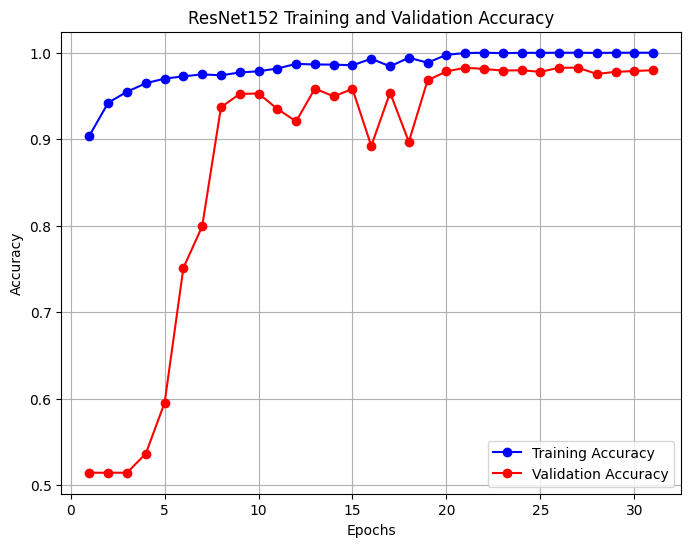

In [ ]:
import matplotlib.pyplot as plt

# Extract accuracy values
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('ResNet152 Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


# Loss graph

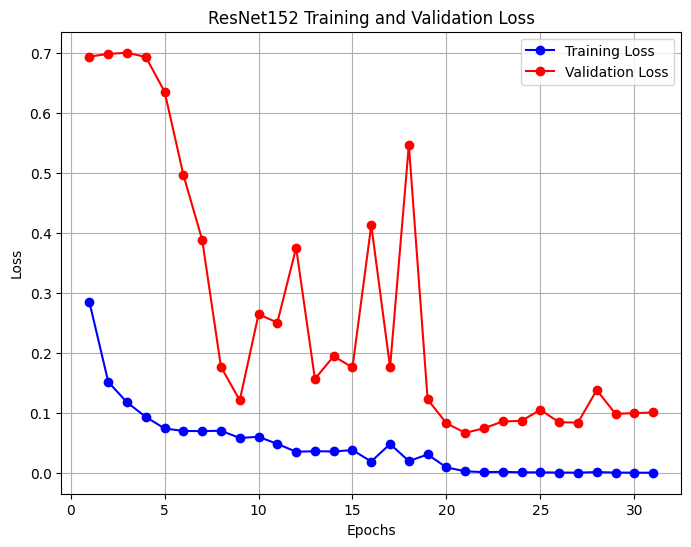

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 6))
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('ResNet152 Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# confusion Matrix

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


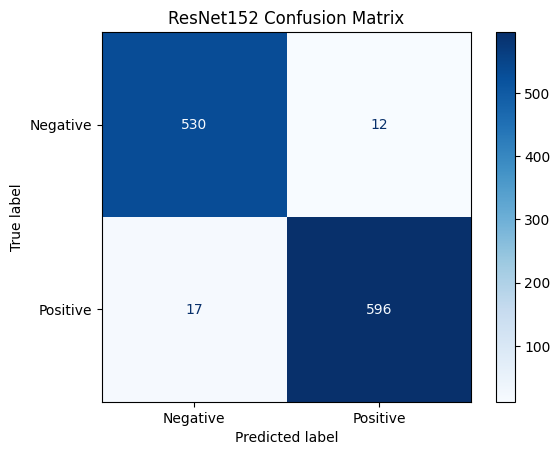

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict probabilities
y_pred_probs = model.predict(x_test)

# Assuming a threshold of 0.5 for binary classification
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)


# Get the class names in the same order
class_labels = ['Negative', 'Positive']

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)

# Add a title to the plot
plt.title("ResNet152 Confusion Matrix")

# Turn off grid lines for a cleaner display
plt.grid(False)

# Show the final plot
plt.show()


In [ ]:
model.save('/content/drive/MyDrive/Optimized_ResNet152_model.keras')

In [ ]:
model = load_model("/content/drive/MyDrive/Optimized_ResNet152_model.keras")

# Grad_CAM

In [ ]:
# Function to generate Grad-CAM heatmap
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Get gradients of the predicted class w.r.t. the last conv layer
    grads = tape.gradient(class_channel, conv_outputs)

    # Compute guided gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply pooled grads with conv layer outputs
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [ ]:
def display_gradcam(image, heatmap, alpha=0.4, cmap='viridis'):
    # Resize heatmap to match image size
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))

    # Convert to RGB
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superimpose
    superimposed_img = cv2.addWeighted(image, 1 - alpha, heatmap, alpha, 0)
    return superimposed_img


Using conv layer: conv5_block3_out


<ipython-input-27-2094777201>:6: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)


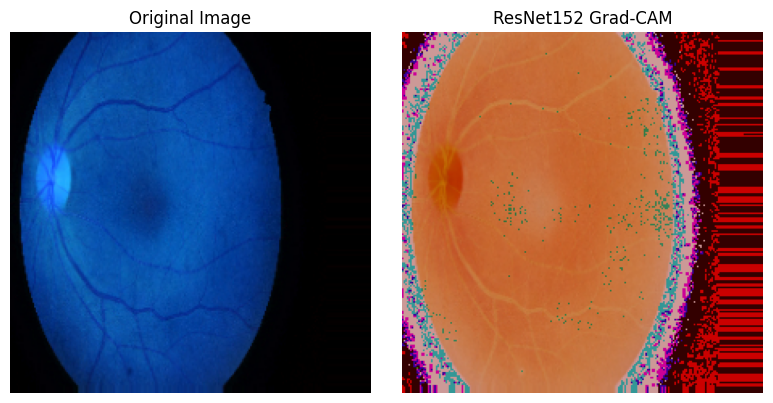

In [ ]:
from tensorflow.keras.applications.efficientnet import preprocess_input
import matplotlib.pyplot as plt

img_path = '/content/drive/MyDrive/Aug_Dataset1/positive/aug_1071_image_00071.png'
img = cv2.imread(img_path)
img = cv2.resize(img, (224, 224))
img_array = np.expand_dims(img, axis=0)
img_array = preprocess_input(img_array)

# Get the name of the last conv layer
last_conv_layer_name = 'conv5_block3_out'
print("Using conv layer:", last_conv_layer_name)

# Generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Convert image to displayable uint8
img_uint8 = np.uint8(img * 255)

# Overlay heatmap
gradcam_result = display_gradcam(img_uint8, heatmap)

# Show image
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("ResNet152 Grad-CAM")
plt.imshow(gradcam_result)
plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
for i, layer in enumerate(model.layers):
    try:
        print(i, layer.name, layer.output.shape)
    except:
        print(i, layer.name, "No shape info")

0 input_layer (None, 224, 224, 3)
1 conv1_pad (None, 230, 230, 3)
2 conv1_conv (None, 112, 112, 64)
3 conv1_bn (None, 112, 112, 64)
4 conv1_relu (None, 112, 112, 64)
5 pool1_pad (None, 114, 114, 64)
6 pool1_pool (None, 56, 56, 64)
7 conv2_block1_1_conv (None, 56, 56, 64)
8 conv2_block1_1_bn (None, 56, 56, 64)
9 conv2_block1_1_relu (None, 56, 56, 64)
10 conv2_block1_2_conv (None, 56, 56, 64)
11 conv2_block1_2_bn (None, 56, 56, 64)
12 conv2_block1_2_relu (None, 56, 56, 64)
13 conv2_block1_0_conv (None, 56, 56, 256)
14 conv2_block1_3_conv (None, 56, 56, 256)
15 conv2_block1_0_bn (None, 56, 56, 256)
16 conv2_block1_3_bn (None, 56, 56, 256)
17 conv2_block1_add (None, 56, 56, 256)
18 conv2_block1_out (None, 56, 56, 256)
19 conv2_block2_1_conv (None, 56, 56, 64)
20 conv2_block2_1_bn (None, 56, 56, 64)
21 conv2_block2_1_relu (None, 56, 56, 64)
22 conv2_block2_2_conv (None, 56, 56, 64)
23 conv2_block2_2_bn (None, 56, 56, 64)
24 conv2_block2_2_relu (None, 56, 56, 64)
25 conv2_block2_3_conv (None

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 176,385,160 (672.86 MB)

 Trainable params: 58,744,578 (224.09 MB)

 Non-trainable params: 151,424 (591.50 KB)

 Optimizer params: 117,489,158 (448.19 MB)